In [53]:
import sys
# sys.path.append('/home/gperri-ext/master_thesis_tryout-2/')
sys.path.append(r"C:\Users\Giova\thesis\master_thesis//")


import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.disable_v2_behavior() # for shap

import keras_tuner as kt
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, ConvLSTM1D, TimeDistributed, Flatten, Dropout, RepeatVector, Activation, ReLU, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split


from models.evaluation_func import single_timeseries_evaluation_metrics_func, evaluate_and_plot_timeseries, NMAE_error
from models.visualization import plot_model_loss, plot_error_metrics_barchart, plot_model_rmse_and_loss
from models.windowing_data import multivariate_data, prepare_dataset_for_training
from models.temp_features import make_yearly_dataset, create_cyclic_features, transform_time_features
from models.daily_errors import errors_on_rows, calculate_rmse_errors


from tensorflow import keras, config
from keras import layers

physical_devices = config.list_physical_devices('GPU') 
try:
    config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

%matplotlib inline


In [30]:
# PYTHON NON RICARICA AUTOMATICAMENTE I MODULI
from importlib import reload
import models.daily_errors


In [31]:
reload(models.daily_errors)

<module 'models.daily_errors' from 'C:\\Users\\Giova\\thesis\\master_thesis\\models\\daily_errors.py'>

### Importing data

In [32]:
data_folder = r"C:\Users\Giova\thesis\master_thesis\data//"
# data_folder = "/home/gperri-ext/master_thesis_tryout-2/"

file_name = "every_zone.csv"

try:
    file_path = os.path.join(data_folder, file_name)
    df = pd.read_csv(file_path)
    
except FileNotFoundError:
    print("File not found. Please provide the correct path to the data folder.")

In [33]:
df.set_index('Time_data', inplace=True)
df.index = pd.to_datetime(df.index)

### Preparing I/O

In [34]:
# df.columns
# df_temp = df[['PUN','PUN_d+1-7','GAS','GiornoSettimana', 'Ora', 'holiday']]

In [35]:
# Choose dataset input
dataset_input = make_yearly_dataset(df, 2018, 2020)
print(dataset_input.tail(5))

                           Ora    PUN   CNOR   CSUD   NORD   SARD    SICI  \
Time_data                                                                   
2020-12-31 19:00:00+00:00   20  63.74  60.54  60.54  60.54  60.54  104.39   
2020-12-31 20:00:00+00:00   21  60.21  56.75  56.75  56.75  56.75  103.39   
2020-12-31 21:00:00+00:00   22  53.69  52.44  52.44  52.44  52.44   69.80   
2020-12-31 22:00:00+00:00   23  53.82  51.86  51.86  51.86  51.86   79.05   
2020-12-31 23:00:00+00:00   24  54.19  52.26  52.26  52.26  52.26   79.05   

                             SUD  Italia_load  CNOR_load  ...  SICI_load  \
Time_data                                                 ...              
2020-12-31 19:00:00+00:00  60.54     33688.45    3679.68  ...    2460.82   
2020-12-31 20:00:00+00:00  56.75     31429.98    3350.05  ...    2330.14   
2020-12-31 21:00:00+00:00  52.44     29024.07    3098.41  ...    2101.06   
2020-12-31 22:00:00+00:00  51.86     26823.84    2871.50  ...    1929.68   
2020

In [36]:
def plot_normalized_std(pun_column, window_size=24):
    """
    Plot the fit and residuals of the PUN.

    Args:
        pun_column (Series): The column containing PUN values.
        window_size (int, optional): Size of the moving window for calculating trends. Defaults to 24.
    """
    # Calculate rolling mean and standard deviation
    pun_mean = pun_column.rolling(window=window_size).mean()
    pun_std = pun_column.rolling(window=window_size).std()

    # Calculate normalized standard deviation
    normalized_std = pun_std / pun_mean

    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # Plot mean on the first subplot
    ax1.plot(pun_column.index, pun_mean, label='Mean', color='blue')
    ax1.set_ylabel('Mean')
    ax1.tick_params(axis='y')
    ax1.grid(True)
    ax1.legend()

    # Plot normalized standard deviation on the second subplot
    ax2.plot(pun_column.index, normalized_std, label='Normalized Std Dev', color='orange')
    ax2.set_ylabel('Normalized Std Dev')
    ax2.tick_params(axis='y')
    ax2.grid(True)
    ax2.legend()

    plt.xlabel('Time Index')
    plt.grid(True)
    plt.show()


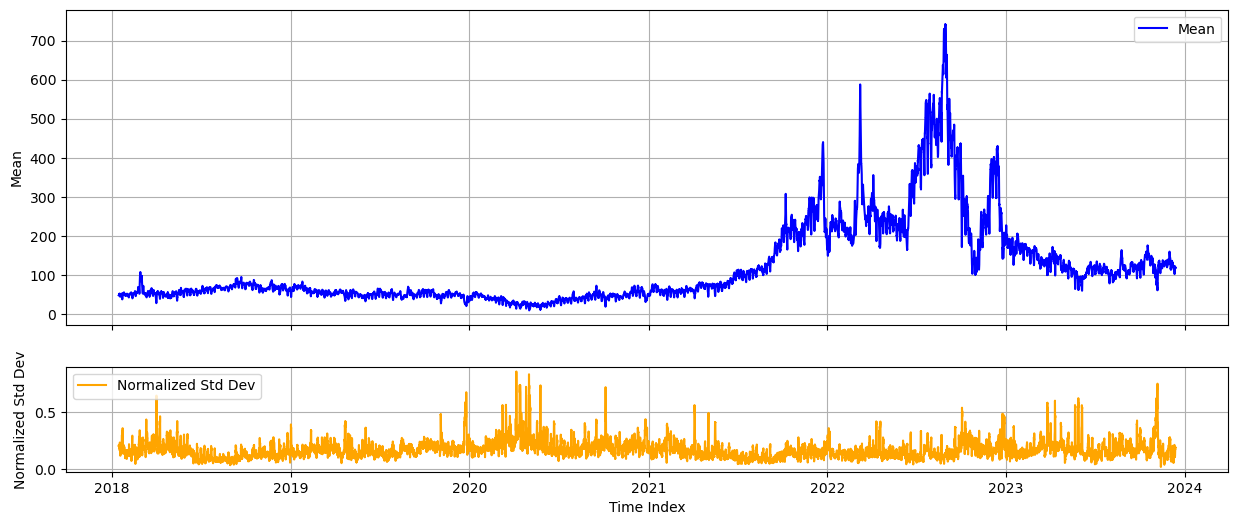

In [37]:
# Example usage
plot_normalized_std(df['PUN'])


In [38]:
target_size = 24
past_history = 24
train_size = 0.7
test_size = 0.3

train_index = int(len(dataset_input) * train_size)
test_index = train_index + int(len(dataset_input) * test_size)

In [39]:
univariate = False

X, y = prepare_dataset_for_training(dataset_input, target_column='PUN', univariate=univariate)

In [40]:
# Utilizza due scaler diversi per evitare bias
X_sc = MinMaxScaler()
y_sc = MinMaxScaler()

X_sc.fit(X[:train_index])
y_sc.fit(y[:train_index])

X_norm = X_sc.transform(X)
y_norm = y_sc.transform(y)


y_norm = y_norm.squeeze()


In [41]:
step = 1

# Prepara i dati utilizzando la funzione multivariate_data
X_train, y_train = multivariate_data(X_norm, y_norm,
                                        0, train_index, past_history,
                                        target_size, step=step, single_step=False)

X_test, y_test = multivariate_data(X_norm, y_norm,
                                    train_index, test_index, past_history,
                                    target_size, step=step, single_step=False)

# Stampa le dimensioni dei dati
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)



X_train shape: (18194, 24, 22)
y_train shape: (18194, 24)
X_test shape: (7728, 24, 22)
y_test shape: (7728, 24)


In [42]:
y_test_inv = y_sc.inverse_transform(y_test)
input_shape = X_train.shape[-2:]


### Single Trial

In [43]:
tf.keras.backend.clear_session()

multivariate_cnn_lstm = tf.keras.models.Sequential([
    Conv1D(filters=64, kernel_size=6,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    LSTM(250, return_sequences=True),
    Dropout(0.2),
    Flatten(),
    Dense(target_size)
])

In [44]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn_lstm_df.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=4e-4, amsgrad=True)

multivariate_cnn_lstm.compile(loss='mean_squared_error', optimizer='adam',
                            metrics=[tf.keras.metrics.RootMeanSquaredError()]) 

In [45]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
            lambda epoch: 1e-5 * 10**(epoch/20))

early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0002, restore_best_weights=True)


history = multivariate_cnn_lstm.fit(X_train, y_train, epochs=50, verbose=1,
                                validation_split=0.2, batch_size=64,
                                callbacks=[early_stopping, lr_schedule])


# multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.h5')


Train on 14555 samples, validate on 3639 samples
Epoch 1/50
14528/14555 [============================>.] - ETA: 0s - loss: 0.0512 - root_mean_squared_error: 0.2262

c:\Users\Giova\anaconda3_new\Lib\site-packages\keras\src\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


14555/14555 [==============================] - 10s 685us/sample - loss: 0.0511 - root_mean_squared_error: 0.2260 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0876 - lr: 1.0000e-05
Epoch 2/50
14555/14555 [==============================] - 10s 675us/sample - loss: 0.0116 - root_mean_squared_error: 0.1075 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0801 - lr: 1.1220e-05
Epoch 3/50
14555/14555 [==============================] - 10s 687us/sample - loss: 0.0095 - root_mean_squared_error: 0.0977 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0732 - lr: 1.2589e-05
Epoch 4/50
14555/14555 [==============================] - 10s 675us/sample - loss: 0.0080 - root_mean_squared_error: 0.0895 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0686 - lr: 1.4125e-05
Epoch 5/50
14555/14555 [==============================] - 12s 843us/sample - loss: 0.0070 - root_mean_squared_error: 0.0834 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0656 - lr: 1.5849e-05
Epoch 6/50
14555/1455

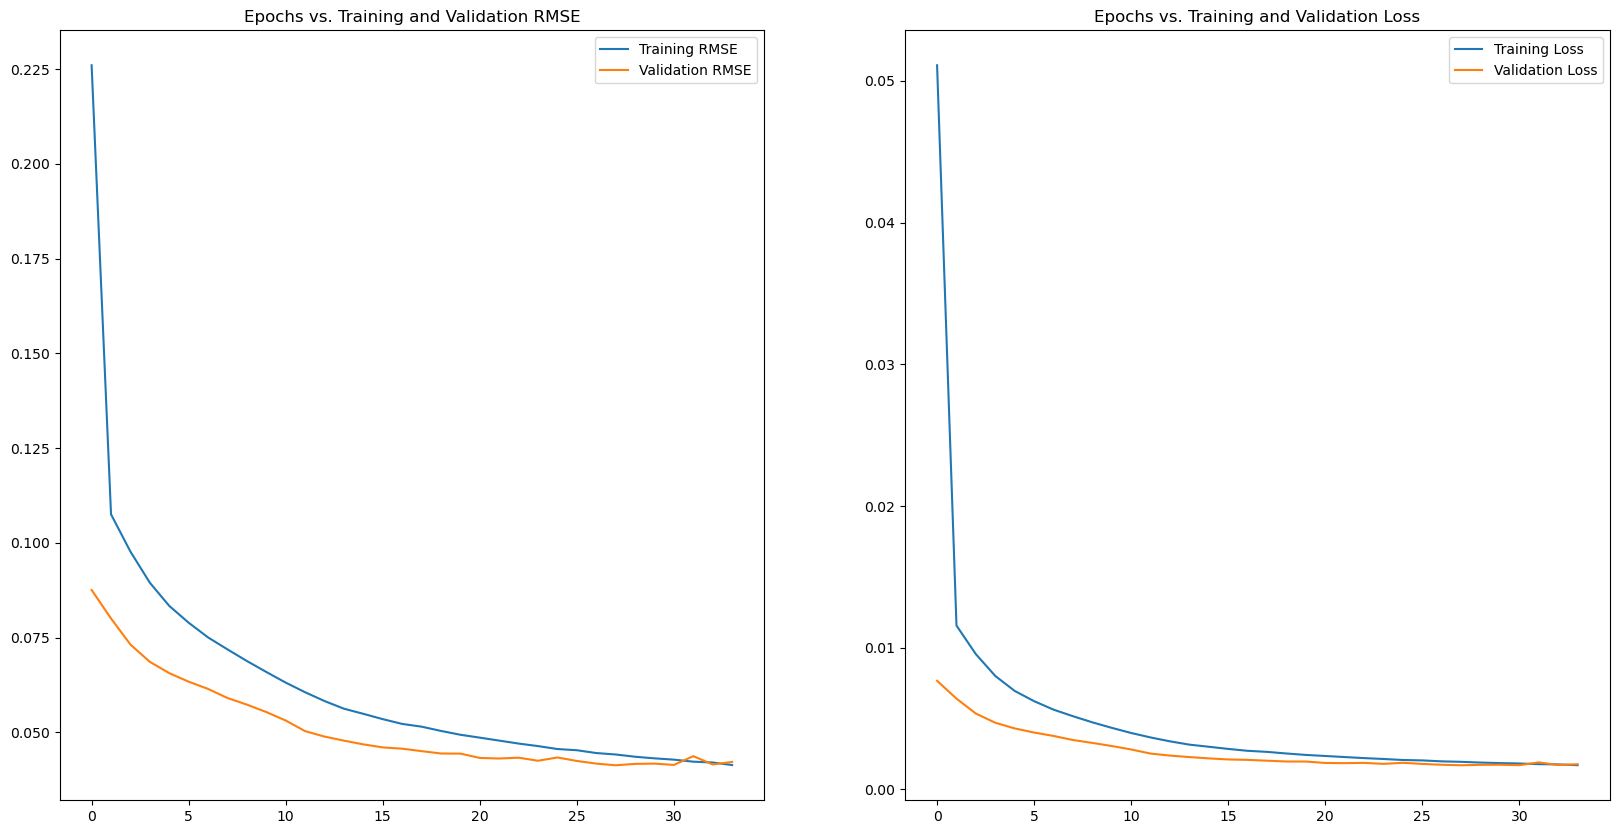

In [46]:
plot_model_rmse_and_loss(history)

In [47]:
cnn_lstm_forecast = multivariate_cnn_lstm.predict(X_test)
cnn_lstm_forecast = y_sc.inverse_transform(cnn_lstm_forecast)

c:\Users\Giova\anaconda3_new\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [48]:
np.where(y_test_inv < 1)

(array([1260, 1261, 1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270,
        1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281,
        1282, 1283, 1427, 1428, 1428, 1429, 1429, 1429, 1430, 1430, 1430,
        1431, 1431, 1431, 1432, 1432, 1432, 1433, 1433, 1433, 1434, 1434,
        1434, 1435, 1435, 1435, 1436, 1436, 1436, 1437, 1437, 1437, 1438,
        1438, 1438, 1439, 1439, 1439, 1440, 1440, 1440, 1441, 1441, 1441,
        1442, 1442, 1442, 1443, 1443, 1443, 1444, 1444, 1444, 1445, 1445,
        1445, 1446, 1446, 1446, 1447, 1447, 1447, 1448, 1448, 1448, 1449,
        1449, 1449, 1450, 1450, 1450, 1450, 1451, 1451, 1451, 1451, 1452,
        1452, 1452, 1452, 1453, 1453, 1453, 1453, 1454, 1454, 1454, 1454,
        1455, 1455, 1455, 1455, 1456, 1456, 1456, 1456, 1457, 1457, 1457,
        1457, 1458, 1458, 1458, 1458, 1459, 1459, 1459, 1459, 1460, 1460,
        1460, 1460, 1461, 1461, 1461, 1461, 1462, 1462, 1462, 1462, 1463,
        1463, 1463, 1463, 1464, 1464, 

In [49]:
y_test_inv[np.where(y_test_inv < 1)] = 1

Min NMAE: 0.137 for Column: 0.0
Min RMSE: 6.883 for Column: 0.0
Min MAPE: 21.774 for Column: 1.0
Mean NMAE: 0.1679166666666667
Mean RMSE: 8.322249999999999
Mean MAPE: 28.194958333333332


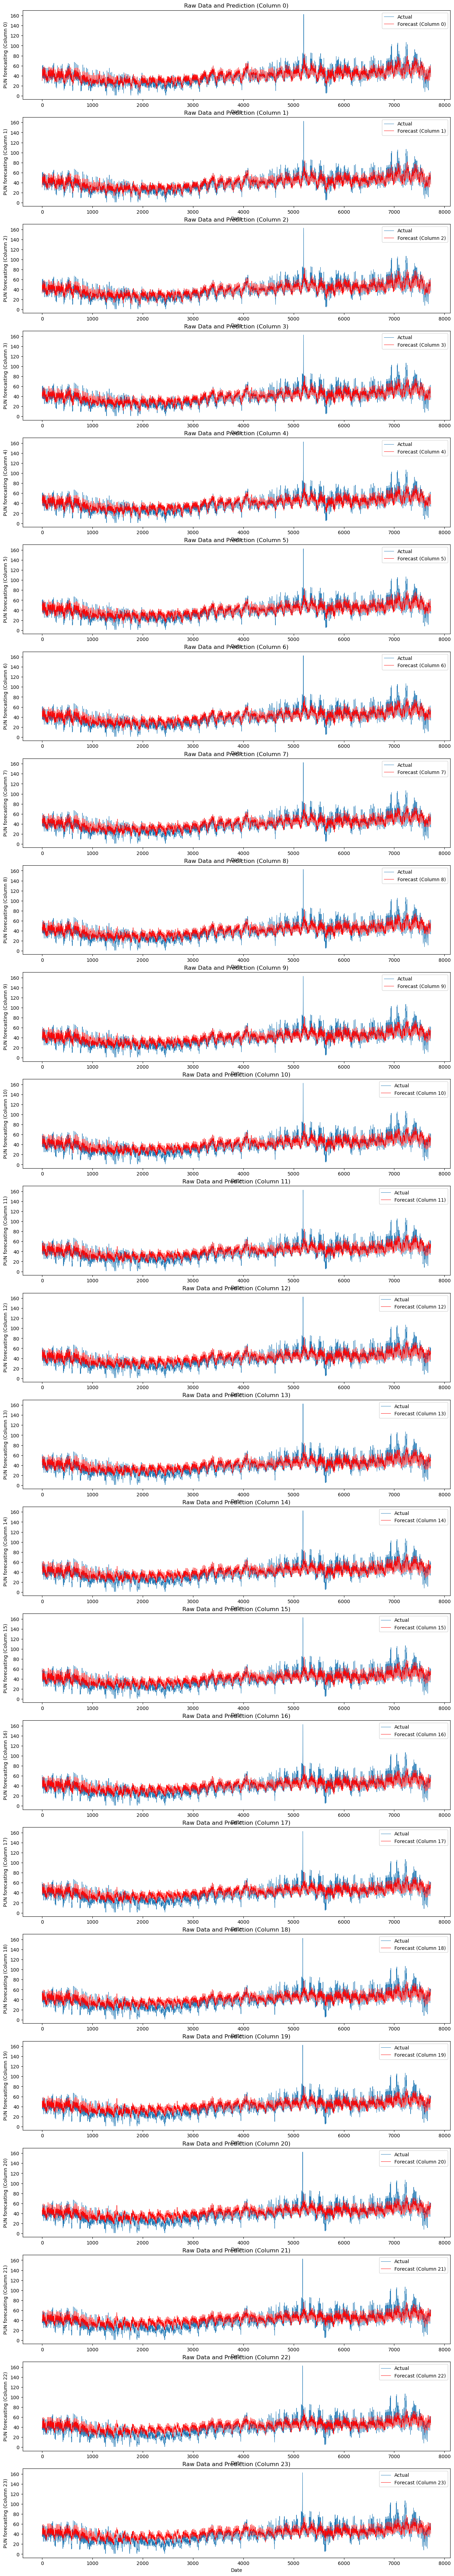

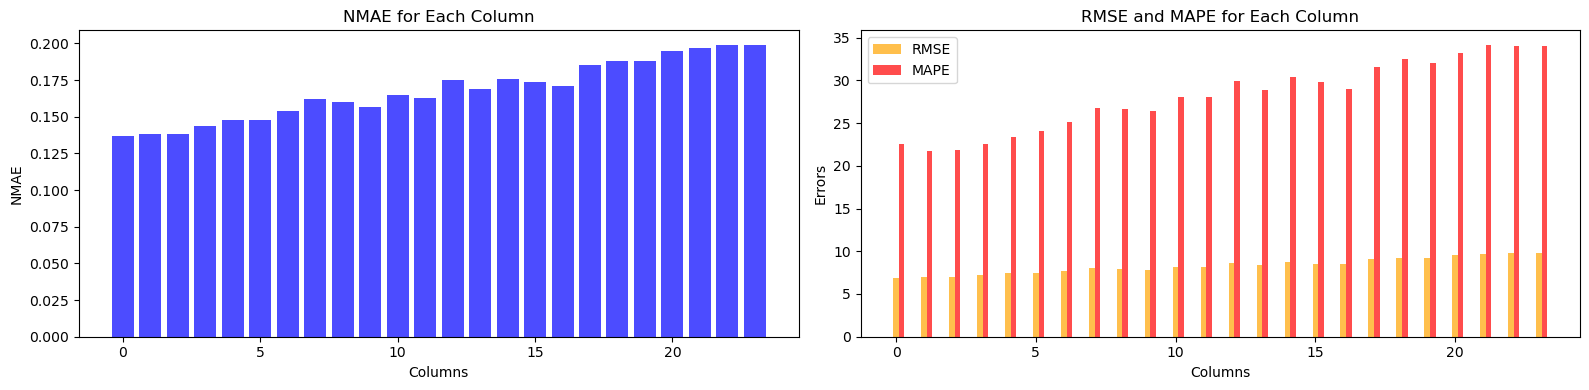

In [55]:
cnn_lstm_table = evaluate_and_plot_timeseries(y_test_inv, cnn_lstm_forecast, show_plot=True)

plot_error_metrics_barchart(cnn_lstm_table)


#### Error on rows instead of columns 

In [51]:
NMAE_error(y_test_inv, cnn_lstm_forecast)

0.16781087998840644

Errore relativo a 322 giorni, a partire da mezzanotte


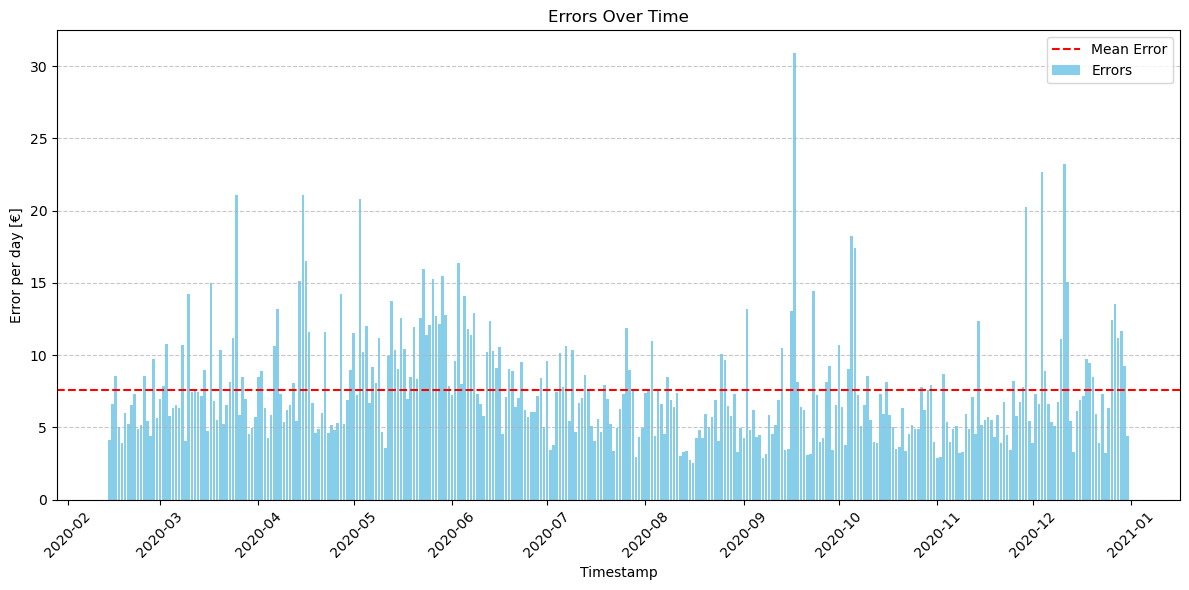

Mean Error (calculate_rmse_errors): 7.6050189247725895


In [54]:
# da sistemare, vorrei aggiungere che scegli anche la metrica degli errori
cnn_mean_error = errors_on_rows(y_test_inv, cnn_lstm_forecast, dataset_input, calculate_rmse_errors)

### Error distribution

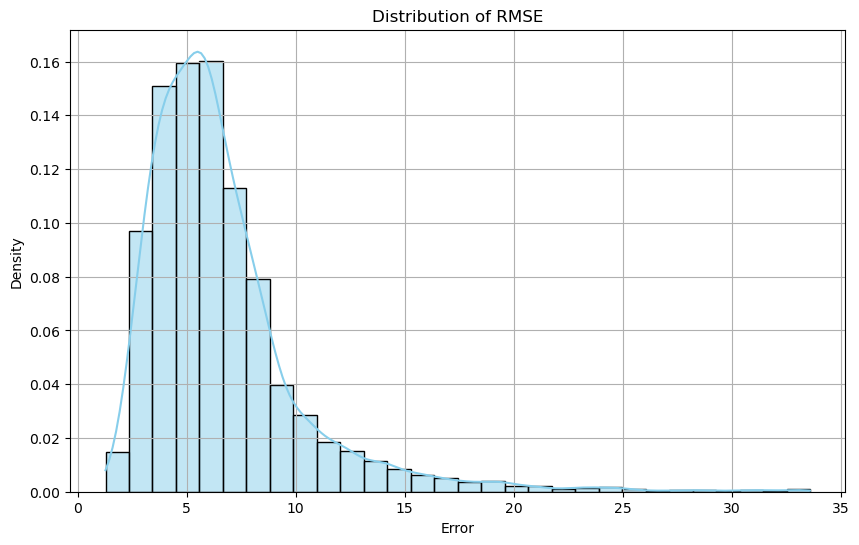

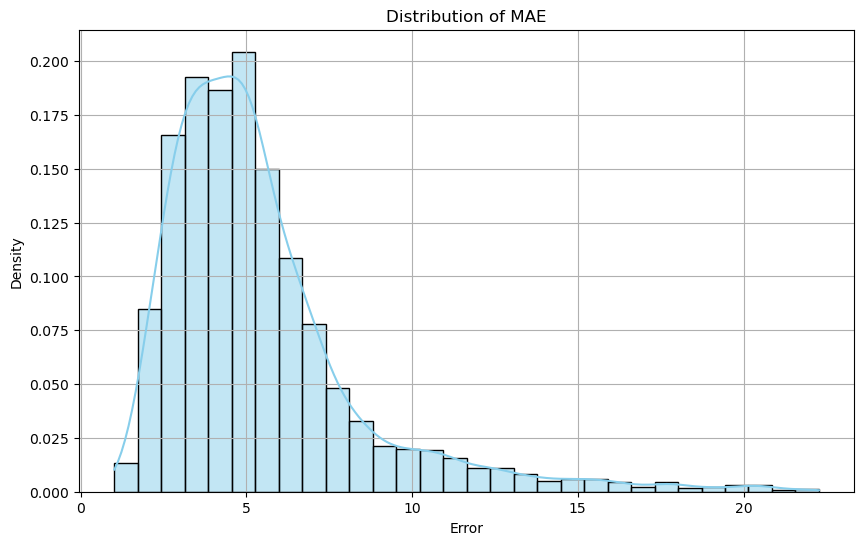

In [102]:
rmse_errors = calculate_rmse_errors(y_test_inv, cnn_lstm_forecast)
plot_error_distribution(rmse_errors, "RMSE")

mae_errors = calculate_mae_errors(y_test_inv, cnn_lstm_forecast)
plot_error_distribution(mae_errors, "MAE")
